In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Data Preparation

In [2]:
df_train = pd.read_csv('train_data.csv') 
df_test = pd.read_csv('test_data.csv')

In [3]:

df_train = df_train.drop(columns=[
     'averageRating', 'originalTitle', 
])

df_test = df_test.drop(columns=[
     'averageRating', 'originalTitle', 
])

In [4]:
my_dict = {
    '(0, 1]': 0,
    '(1, 2]': 0,
    '(2, 3]': 0,
    '(3, 4]': 0,
    '(4, 5]': 1,
    '(5, 6]': 1,
    '(6, 7]': 2,
    '(7, 8]': 3,
    '(8, 9]': 4,
    '(9, 10]': 5,
}
df_train['rating'] = df_train['rating'].map(my_dict)
df_test['rating'] = df_test['rating'].map(my_dict)

In [5]:
X_train = df_train.drop(columns=["rating"])
y_train = df_train["rating"]
X_test = df_test.drop(columns=["rating"])
y_test = df_test["rating"]

In [6]:
X_train.shape

(103679, 21)

In [7]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [8]:
from sklearn.utils.class_weight import compute_sample_weight

# This replicates class_weight='balanced'
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


reg_lambda': 0.1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0}

# XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_intro.html

In [9]:
# !pip install xgboost

In [10]:
from xgboost import XGBClassifier

In [11]:
clf = XGBClassifier(objective='multi:softprob', 
                    n_estimators=500,
                    max_depth = 6,
                    learning_rate = 0.1,
                    gamma = 0.5,
                    reg_lambda = 0,
                    reg_alpha = 1,
                    tree_method='exact', # 'approx'
                    random_state=42,
                  
                   )
clf.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.3942162709575785
F1-score [0.25927862 0.48124438 0.34631158 0.47513768 0.34830041 0.21361856]
              precision    recall  f1-score   support

           0       0.18      0.48      0.26      1547
           1       0.49      0.47      0.48      9052
           2       0.45      0.28      0.35     11574
           3       0.56      0.41      0.48     14409
           4       0.31      0.40      0.35      6571
           5       0.13      0.55      0.21      1282

    accuracy                           0.39     44435
   macro avg       0.35      0.43      0.35     44435
weighted avg       0.46      0.39      0.41     44435



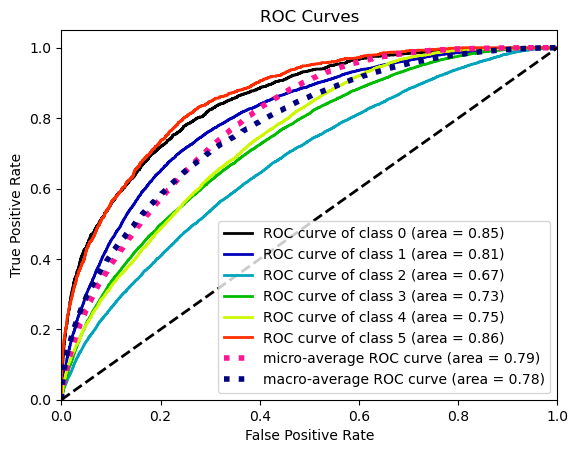

In [12]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

In [15]:
from scikitplot.metrics import plot_confusion_matrix
import seaborn as sns

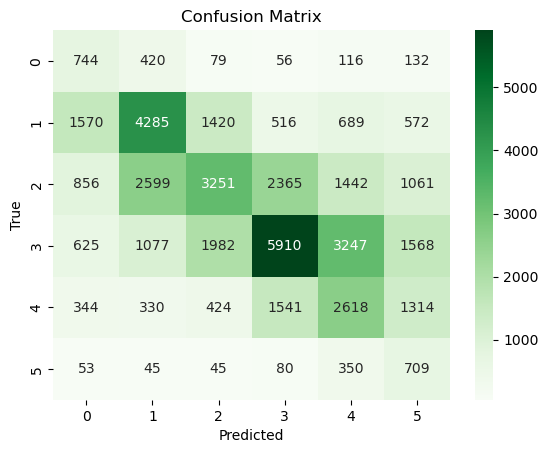

In [16]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')  # fmt='d' to show integer values
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [17]:
import shap
shap.initjs()

In [18]:
# Get predictions for first observation
clf.predict(X_test)[0]

2

In [19]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test)

print(shap_values.shape)

(44435, 21, 6)


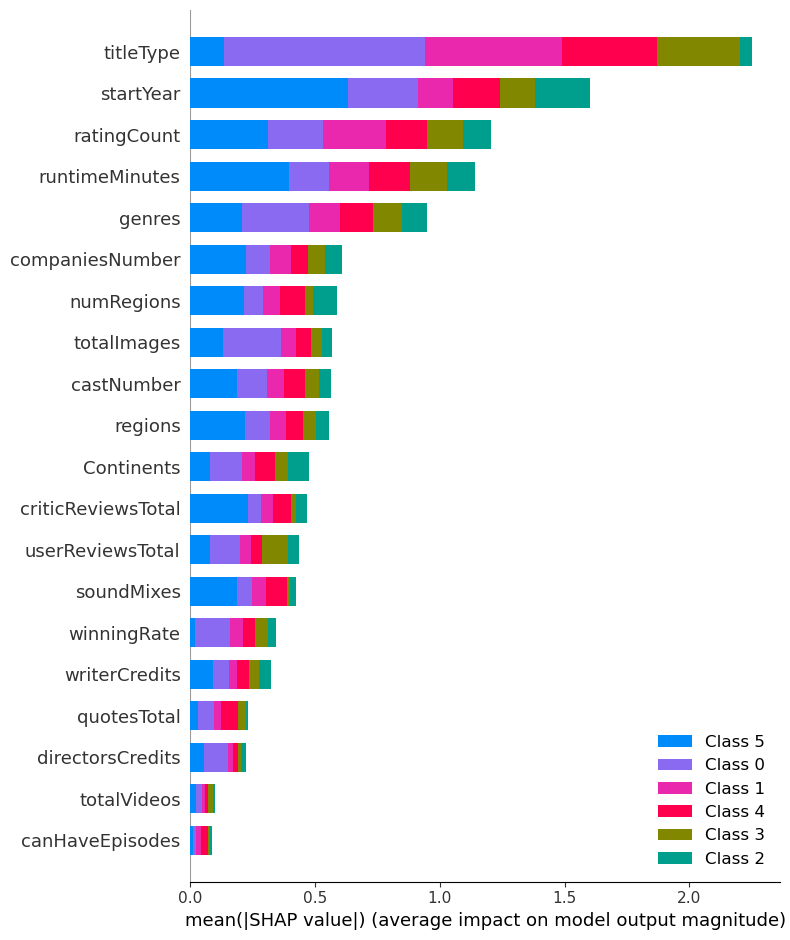

In [20]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

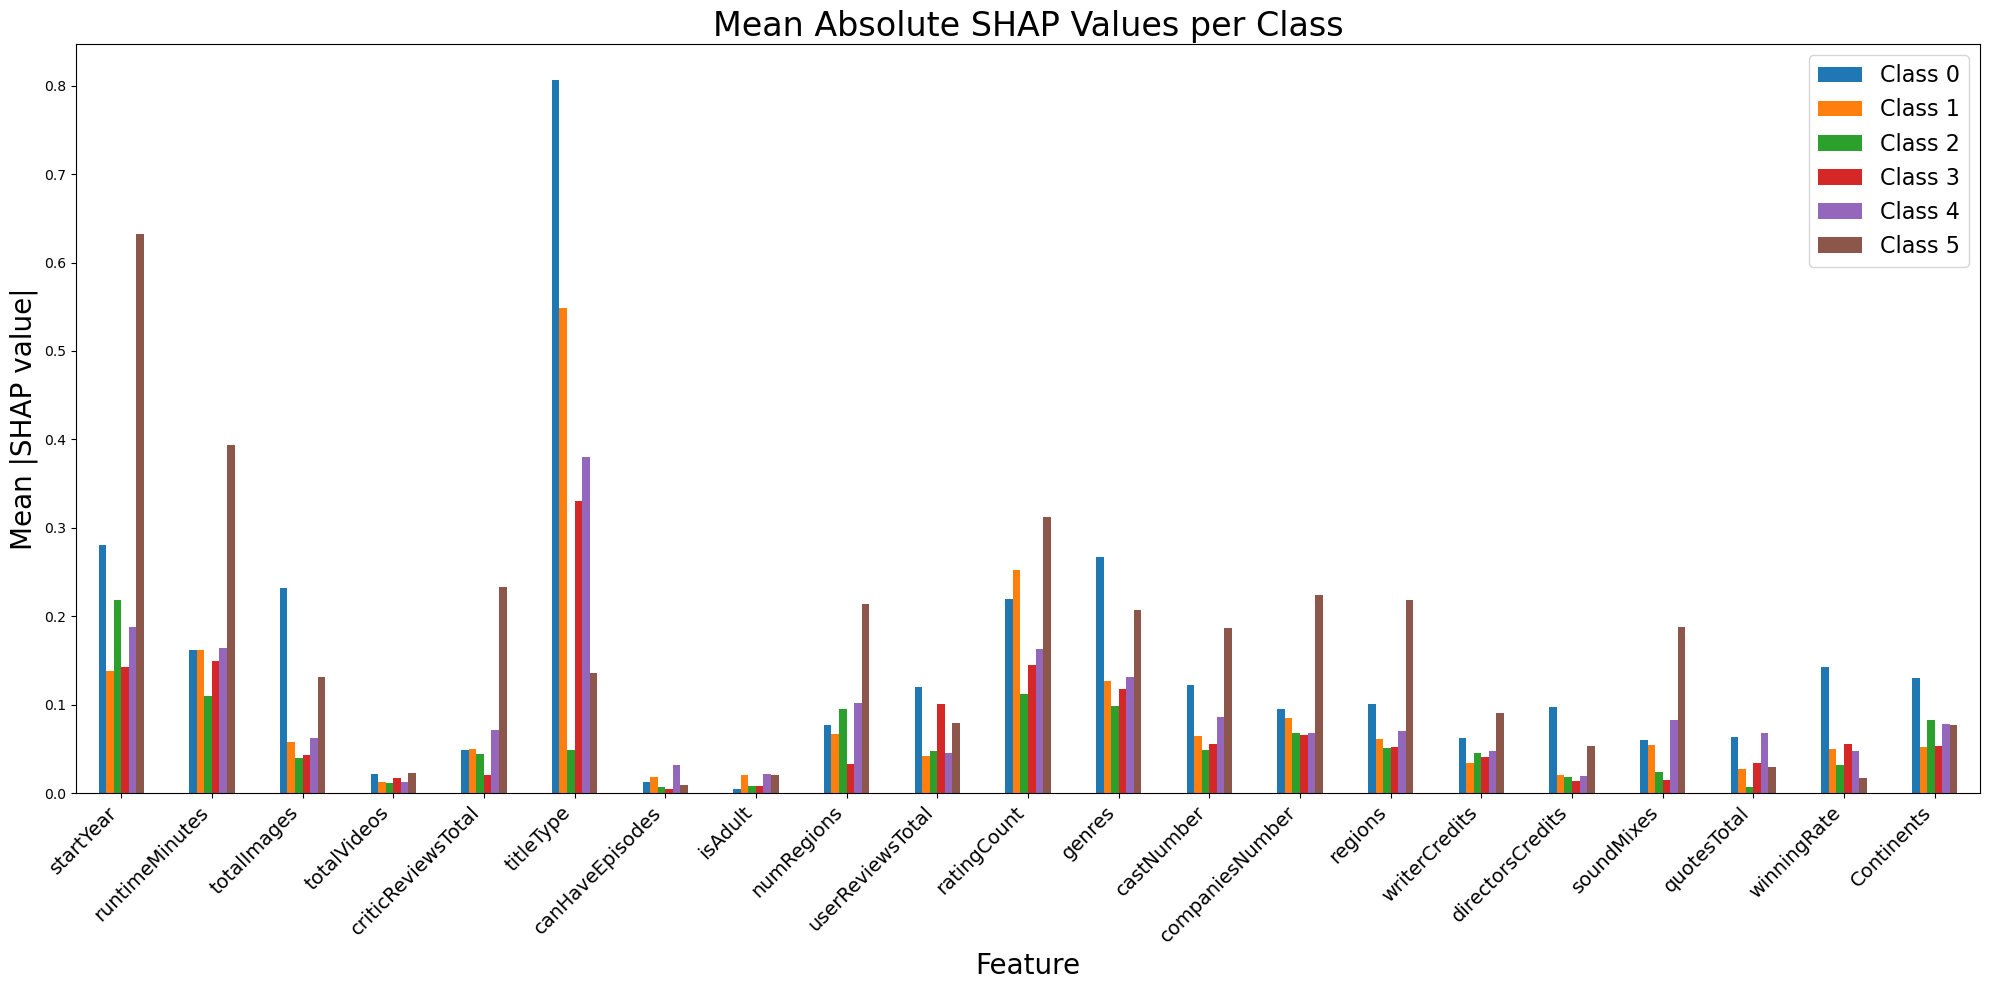

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of classes
num_classes = shap_values.shape[2]  # returns 6 # Assuming shap_values is of shape (num_samples, num_features, num_classes)

# Create a dictionary to store mean SHAP values for each class
mean_shap_per_class = {}

for class_idx in range(num_classes):
    mean_shap = np.mean(np.abs(shap_values.values[:, :, class_idx]), axis=0)
    mean_shap_per_class[f"Class {class_idx}"] = mean_shap

# Convert to DataFrame
df = pd.DataFrame(mean_shap_per_class, index=X_test.columns)

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
df.plot.bar(ax=ax)

ax.set_ylabel("Mean |SHAP value|", size=20)
ax.set_xlabel("Feature", size=20)
ax.set_title("Mean Absolute SHAP Values per Class", size=24)
ax.legend(fontsize=16)
ax.set_xticklabels(X_test.columns, rotation=45, ha='right', fontsize=14)

plt.tight_layout()
plt.show()


Observation 2244
✅ True class: 4
🔮 Predicted class: 5

🔍 SHAP explanation for predicted class (5):


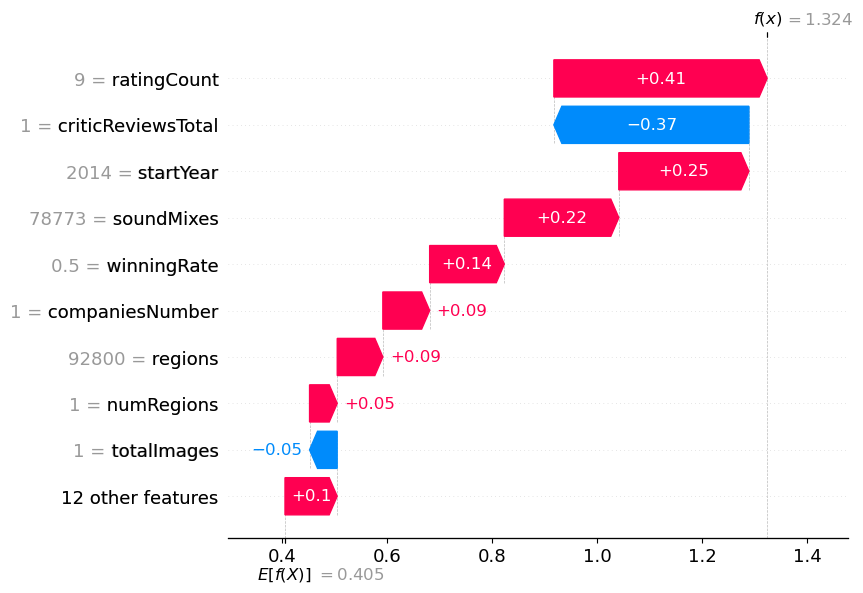

In [22]:
import matplotlib.pyplot as plt

# Choose the observation index you want to analyze
i = 2244
  # First observation

# Get predicted and true classes
predicted_class = clf.predict(X_test)[i]
true_class = y_test[i]

print(f"Observation {i}")
print(f"✅ True class: {true_class}")
print(f"🔮 Predicted class: {predicted_class}")

# Plot SHAP waterfall for predicted class
print(f"\n🔍 SHAP explanation for predicted class ({predicted_class}):")
shap.plots.waterfall(shap_values[i, :, predicted_class])




Observation 786
✅ True class: 5
🔮 Predicted class: 5

🔍 SHAP explanation for predicted class (5):


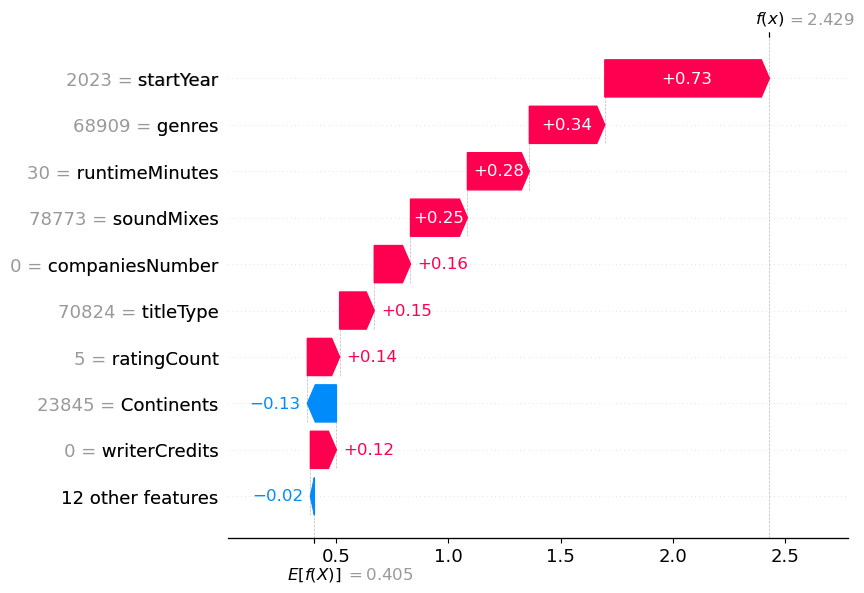

In [23]:
import matplotlib.pyplot as plt

# Choose the observation index you want to analyze
i = 786  # First observation

# Get predicted and true classes
predicted_class = clf.predict(X_test)[i]
true_class = y_test[i]

print(f"Observation {i}")
print(f"✅ True class: {true_class}")
print(f"🔮 Predicted class: {predicted_class}")

# Plot SHAP waterfall for predicted class
print(f"\n🔍 SHAP explanation for predicted class ({predicted_class}):")
shap.plots.waterfall(shap_values[i, :, predicted_class])


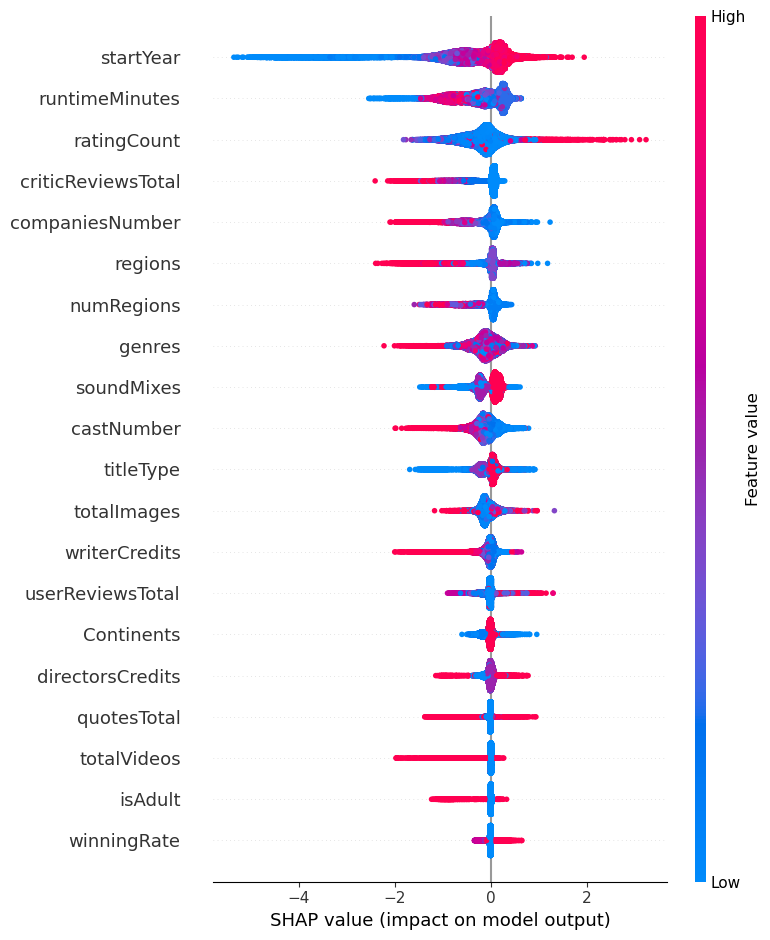

In [24]:
class_index = 5  # or 0–4 for other classes

shap.summary_plot(
    shap_values.values[:, :, class_index],
    X_test,
    plot_type="dot",           # Beeswarm
    class_names=['0','1','2','3','4','5'],
    feature_names=X_test.columns
)


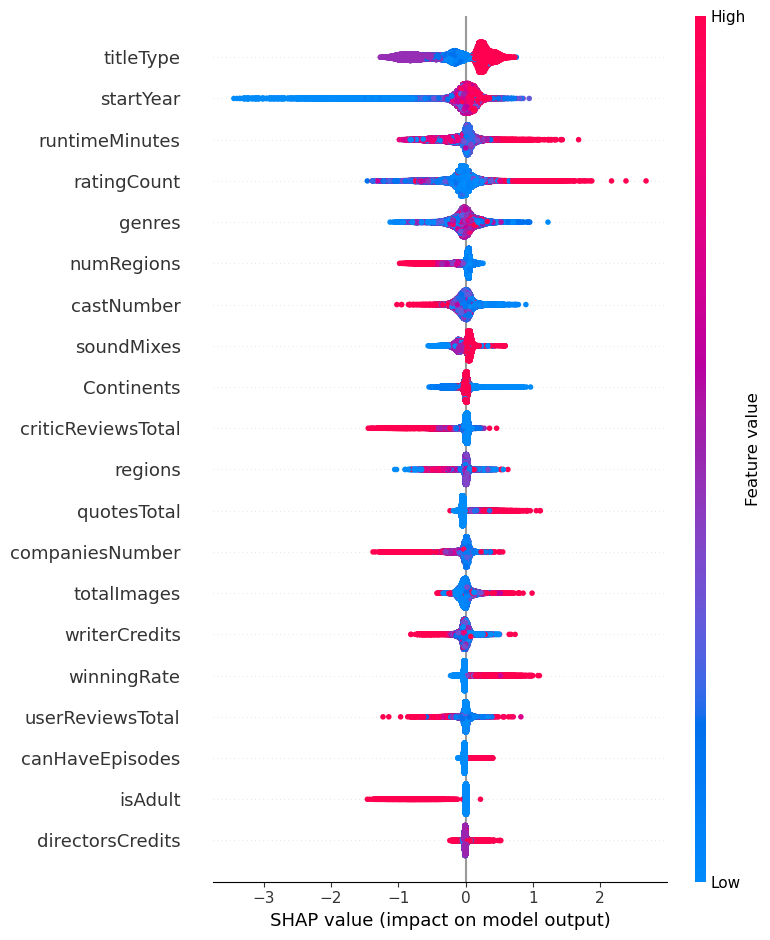

In [25]:
class_index = 4  # or 0–4 for other classes

shap.summary_plot(
    shap_values.values[:, :, class_index],
    X_test,
    plot_type="dot",           # Beeswarm
    class_names=['0','1','2','3','4','5'],
    feature_names=X_test.columns
)
